In [1]:
# Implementation of deepmind's paper on Wavenets, which requires implementing a dilated causal convolutional network.
# Let us rewrite makemore first and make it a bit more mature

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

# Load data
words = open('names.txt','r').read().splitlines()
# Tokenize the input
chars = sorted(list(set(''.join(words))))# Make the items and chars to pull out a non repeating vocabulary of characters from the dataset.
# make a numeric identifier for each unique character
s2i = {s:i+1 for i,s in enumerate(chars)}
s2i['.'] = 0 # add an identifier which you can use to denote the beginning and end of each character (in the original paper, this is word)
# reverse the order
i2s = {i:s for s,i in s2i.items()} # this switches the key of the dictionary, making numerals identify a character, which is needed for languages.



In [21]:
block_size = 8 # number of inputs going into the network, i.e., number of characters.
# Step 1) Build the dataset
def build_dataset(words, block_size):
    
    X, Y = [],[] # X is the inputs (block_size in number), while Y is the output, which is one for this example.

    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = s2i[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(i2s[i] for i in context), '---->', i2s[ix])
            #print(context[1:] + [ix])
            context = context[1:] + [ix]

    # convert to torch datasets
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

# Split dataset into training set and test set
random.seed(0)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1],block_size) # training set is 0.8*len words
Xdev, Ydev = build_dataset(words[n1:n2],block_size) # dev set is between 0.8*len words and 0.9*len words
Xte, Yte = build_dataset(words[n2:],block_size) # test set is 0.9*len words to the end

print(Xtr.shape, Ytr.shape)
print(Xdev.shape, Ydev.shape)
print(Xte.shape, Yte.shape)

torch.Size([182376, 8]) torch.Size([182376])
torch.Size([22871, 8]) torch.Size([22871])
torch.Size([22899, 8]) torch.Size([22899])


In [76]:

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn(fan_in,fan_out) / (fan_in**0.5) # set up initialization as well
        self.bias = torch.zeros(fan_out) if bias else None # conditional

    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return ([self.weight] if self.bias is None else [self.weight, self.bias])


class Embedding:
    def __init__(self,n_embeddings,embedding_dim):
        self.weight = torch.randn((n_embeddings,embedding_dim))
    
    def __call__(self,x):
        self.out = self.weight[x]
        return self.out
    def parameters(self):
        return [self.weight]

class Flatten:
    def __call__(self,x):
        self.out = x.view(x.shape[0],-1)
        return self.out
    def parameters(self):
        return []


class FlattenConsecutive:

    def __init__(self,n): # This means we only flatten some n consequtive elements and puts them into the last dimension
        self.n = n

    def __call__(self,x):
        b,t,c = x.shape
        x = x.view(b,t//self.n,c*self.n) # This is how it works
        if x.shape[1] == 1: # in case the input is a single element, we need to squeeze it
            x = x.squeeze(1) # This removes all singleton dimensions in position dim=1 which means a (bXc*self.n) will be the output size
        self.out = x
        return self.out
        
    def parameters(self):
        return []

class BatchNorm1D:

    def __init__(self,dim,eps=1e-5, momentum=0.9):
        self.eps = eps # set the epsilon to be a small number to prevent division by zero
        self.momentum = momentum
        self.training = True
        # Initialize gamma and beta
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Set running mean and variance to zero and 1
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3: # Remember, that pytorch has a different convention for the batch dimension. They average over (0,2) instead, and expect the classes to be in between.
                dim = (0,1)
            xmean = x.mean(dim,keepdim=True)
            xvar = x.var(dim,keepdim=True) # This is the 2D case
            # torch.mean can take in a tuple of integers to reduce over multiple dimensions
        else:
            xmean = self.running_mean
            xvar = self.running_var
        expression = (x - xmean)/torch.sqrt(xvar + self.eps)
        self.out = self.gamma* (expression) + self.beta
        # Update the running mean and the running variance on the fly:
        if self.training:
            with torch.no_grad(): # avoid gradient being part of the computation graph
                self.running_mean = self.momentum*self.running_mean + (1-self.momentum)*xmean
                self.running_var = self.momentum*self.running_var + (1-self.momentum)*xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
        
class Tanh:

    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


class Sequential:

    def __init__(self,layers):
        self.layers = layers
    
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        self.out=x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [82]:
# Build a simple neural network which you will complexify to add the dilated 
# causal convolutional network

n_embeddings = 24
n_hidden = 128
vocab_size = len(chars) + 1

torch.manual_seed(42) # gets rid of the generator function we used to use previously


model = Sequential([
            Embedding(vocab_size, n_embeddings), 
            FlattenConsecutive(2),Linear(n_embeddings*2, n_hidden, bias = False), BatchNorm1D(n_hidden), Tanh(),
            FlattenConsecutive(2),Linear(n_hidden*2, n_hidden, bias = False), BatchNorm1D(n_hidden), Tanh(),
            FlattenConsecutive(2),Linear(n_hidden*2, n_hidden, bias = False), BatchNorm1D(n_hidden), Tanh(),
            Linear(n_hidden, vocab_size), 
])

# Set up initialization conditions
with torch.no_grad():
    for layer in model.layers[:-1]:
        if isinstance(layer,BatchNorm1D):
            layer.gamma *= 0.1
        if isinstance(layer, Linear):
            layer.weight *= 0.1 # Reduce the co0nfidence of the last layer

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

# Set requires_grad to true
for p in parameters:
    p.requires_grad = True




76579


In [83]:
# Check to see if the model works
ix = torch.randint(0,Xtr.shape[0],(4,))
Xb,Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb
# We now see that our 4 examples have 8 characters in the input

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0, 15],
        [ 0,  0,  0,  0,  0,  0,  0, 12],
        [ 0,  0,  0,  0,  0,  0,  5, 12],
        [ 0,  0,  0, 12,  5, 25, 12,  1]])

In [34]:
# if we look at the shape of the output of the first layer of the model:
print(model.layers[0].out.shape)# we get a 4x8x10 tensor, which is the 4 examples, 8 characters, and 10 embeddings
# checking the next layer:
print(model.layers[1].out.shape) # we get a 4X80 tensor, which is the 4 examples, and 80 flattened embeddings
# checking the next layer:
print(model.layers[2].out.shape) # we get a 4X200 tensor, which is the 4 examples, and 200 hidden units
# so the entire operation up to now is to take the 4X8X10 tensor and concatenate to a 4X200 tensor
# Let us look at what happens in the linear layer mathematically
print((torch.randn(4,80) @ torch.randn(80,200) + torch.randn(200)).shape) # we get a 4X200 tensor, so the addition is a broadcast
# It is surprising to note that the input need not be a 2d tensor:
print((torch.randn(4,5,80) @ torch.randn(80,200) + torch.randn(200)).shape) # we get a 4X200 tensor, so the addition is a broadcast
# Seeing that the added middle dimension is unaffected, we note that the matrix mult is only working on the last dimension
# We can use this for our dilated causal convolutional network
# In our dilated layer, we are not interested in multiplying across all the inputs,
# we want to group them so that every consequtive two elements are taken
# going from [1 2 3 4 5 6 7 8] to [(1,2) (3,4) (5,6) (7,8)]
# This looks like
print((torch.randn(4, 4 ,20) @ torch.randn(20,200) + torch.randn(200)).shape) # giving us a 4X4X200 tensor


torch.Size([4, 8, 10])
torch.Size([4, 80])
torch.Size([4, 200])
torch.Size([4, 200])
torch.Size([4, 5, 200])
torch.Size([4, 4, 200])


In [41]:
# the above requirement means the Flatten layer needs to be changed
# Currently, the following happens:
e = torch.randn(4,8,10)
e.view(4,-1).shape # which gives us a 4X80 tensor
# but we want a 4,4,20 tensor
print(e[:,0::2,:].shape, e[:,1::2,:].shape) # which gives us a 4,4,10 tensor of the even and odd elements in the middle dimension
# Another process is to use the view operation
print(e.view([4,4,20]).shape) # which gives us a 4,4,20 tensor]))

torch.Size([4, 4, 10]) torch.Size([4, 4, 10])
torch.Size([4, 4, 20])


In [44]:
e = torch.randn(4,8,10)
explicit = torch.cat([e[:,0::2,:],e[:,1::2,:]],dim=2)
explicit.shape # This is what we need to get

# We can compare with the view operation
implicit = e.view([4,4,20])
print((explicit-implicit).abs().sum()) # which gives us a 4,4,20 tensor
# Because we get zero, this means that the view operation is equivalent to the concatenation operation
# where the odd and even elements are concatenated along the last dimension, dim=2

tensor(0.)


In [71]:
for layers in model.layers:
    print(layers.__class__.__name__,':',tuple(layers.out.shape))
# This prints the name and layer shape of each layer in the model
# We see that the squeeze operation works.
# The original wavenet paper haws a block size of 16, and 4 dilations of 1,2,4,8 from 16

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1D : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1D : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1D : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


      0/ 200000: 3.2998
  10000/ 200000: 2.1058
  20000/ 200000: 2.4089
  30000/ 200000: 2.2599
  40000/ 200000: 1.7570
  50000/ 200000: 2.3884
  60000/ 200000: 2.1061
  70000/ 200000: 1.8071
  80000/ 200000: 2.0559
  90000/ 200000: 2.1736
 100000/ 200000: 1.7727
 110000/ 200000: 2.0053
 120000/ 200000: 2.2046
 130000/ 200000: 1.9626
 140000/ 200000: 2.2015
 150000/ 200000: 2.2535
 160000/ 200000: 2.0827
 170000/ 200000: 2.0117
 180000/ 200000: 1.7874
 190000/ 200000: 2.0293


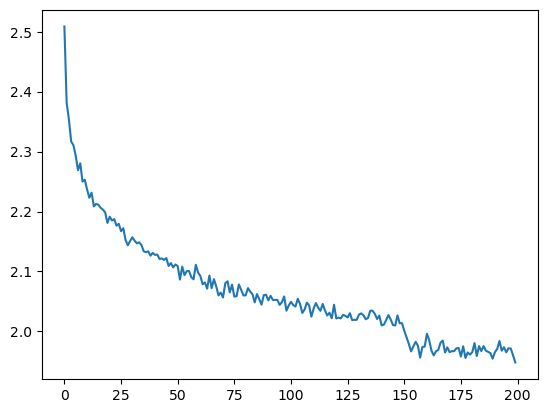

In [79]:
# Begin training 
max_iterations = 200000
batch_size = 32
lossi = []

for i in range(max_iterations):

    # Generate a random batch
    ix = torch.randint(0,Xtr.shape[0],(batch_size,))
    Xb,Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits,Yb)

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update parameters
    lr = 0.1 if i<150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 1000 == 0: # print every once in a while
        print(f'{i:7d}/{max_iterations:7d}: {loss.item():.4f}')
    lossi.append(loss.item())

plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

# Switch off the training on all layers so that the running meand and 
# variance can be used for BatchNorm1D
for layer in model.layers:
    layer.training = False

In [80]:
@torch.no_grad()
def split_loss(split): # loss calculation over a portion of the dataset
    x,y = {
        'train': (Xtr,Ytr),
        'dev': (Xdev,Ydev),
        'test': (Xte,Yte),
    }[split]
    
    logits = model(x)
    loss = F.cross_entropy(logits,y)
    

    print(split,loss.item())

split_loss('train')
split_loss('dev')

train 1.933670997619629
dev 2.0148839950561523


In [81]:
# Sampling from the model

for i in range(20):
    out = []
    context = [0]* block_size

    while True:
        # forward pass
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print(''.join(i2s[i] for i in out))

zhandrus.
faaron.
ala.
yeyeley.
marake.
deylin.
marov.
emmer.
vie.
zeiah.
ymira.
deerthius.
noyry.
janissa.
via.
klina.
barivin.
brinlynn.
caiton.
mubred.
